In [0]:
%tensorflow_version 1.x

In [0]:
import numpy as np
import pandas as pd
import sklearn
from sklearn import tree
from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2

import torch
from torch.autograd import Variable as V
import torchvision.models as models
from torchvision import transforms as trn
from torch.nn import functional as F
import torch.nn as nn
import os
from PIL import Image
import matplotlib.pyplot as plt

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
file_name = 'categories_places365.txt'
if not os.access(file_name, os.W_OK):
    synset_url = 'https://raw.githubusercontent.com/csailvision/places365/master/categories_places365.txt'
    os.system('wget ' + synset_url)
classes = list()
with open(file_name) as class_file:
    for line in class_file:
        classes.append(line.strip().split(' ')[0][3:])
classes = np.array(classes)

In [0]:
arch = 'resnet50'
model_file = f'{arch}_places365.pth.tar'
if not os.access(model_file, os.W_OK):
    weight_url = 'http://places2.csail.mit.edu/models_places365/' + model_file
    os.system('wget ' + weight_url)

model = models.__dict__[arch](num_classes=365)
checkpoint = torch.load(model_file, map_location=lambda storage, loc: storage)
state_dict = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()}
model.load_state_dict(state_dict)

<All keys matched successfully>

In [0]:
model.eval()
for param in model.parameters():
    param.requires_grad = False
'convert model to evaluation mode with no grad'

'convert model to evaluation mode with no grad'

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
feature_extractor = nn.Sequential(*list(model.children())[:-2], nn.AdaptiveAvgPool2d(1)).eval().to(device)

In [0]:
!cp drive/'My Drive'/'Colab Notebooks'/'Automate local TCAV'/'final notebooks'/resized_imgs.pkl  /content/
!cp drive/'My Drive'/'Colab Notebooks'/'Automate local TCAV'/'final notebooks'/masks.pkl  /content/
!cp drive/'My Drive'/'Colab Notebooks'/'Automate local TCAV'/'final notebooks'/classes.pkl  /content/

In [0]:
import pickle
with open('masks.pkl', 'rb') as f:
  masks = pickle.load(f)
with open('resized_imgs.pkl', 'rb') as f:
  imgs = pickle.load(f)
with open('classes.pkl', 'rb') as f:
  labels = np.array(pickle.load(f))

In [0]:
def get_segments(img, mask, threshold = 0.05):
  ade_classes = pd.read_csv('https://raw.githubusercontent.com/CSAILVision/sceneparsing/master/objectInfo150.csv')
  segs = np.unique(mask)
  segments = []
  total = mask.shape[0]*mask.shape[1]
  segments_classes = []
  for seg in segs:
    idxs = mask==seg
    sz = np.sum(idxs)
    if sz < threshold*total:
      continue
    segment = img*idxs[..., None]
    w, h, _ = np.nonzero(segment)
    segment = segment[np.min(w):np.max(w),np.min(h):np.max(h),:]
    segments.append(segment)
    segments_classes.append(ade_classes['Name'].loc[ade_classes['Idx']==seg].iloc[0])
  return segments, segments_classes

In [0]:
img_segments = []
img_segments_classes = []
for img, msk in zip(imgs, masks):
  segss, seg_class = get_segments(np.array(img), msk, threshold = 0.005)
  img_segments_classes.append(seg_class)
  img_segments.append(segss)
img_segments_classes_flattened = np.array([v for vec in img_segments_classes for v in vec])

In [0]:
centre_crop = trn.Compose([
        trn.Resize((256,256)),
        trn.CenterCrop(224),
        trn.ToTensor(),
        # trn.Normalize([0, 0, 0], [255, 255, 225]),
        trn.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [0]:
outputs = []
def hook(module, input, output):
    x = nn.AdaptiveAvgPool2d(1)(output)
    outputs.append(x.cpu().numpy().squeeze())
full_model = model
handle = full_model.layer4[2].register_forward_hook(hook)
full_model.to(device)
'finished the full model with hook attached'

'finished the full model with hook attached'

In [0]:
chosen_classes = ['street', 'bedroom', 'living_room', 'bathroom', 'kitchen', 
            'skyscraper', 'highway', 'conference_room', 'mountain_snowy', 'office',
            'corridor', 'airport_terminal', 'attic', 'mountain', 'park', 'coast', 
            'alley','beach', 'childs_room', 'art_gallery','castle', 'dorm_room', 
            'nursery', 'lobby', 'reception', 'bar', 'house', 'bridge', 'classroom']
num_classes = len(chosen_classes)
idxs = []
for ccls in chosen_classes:
  idx = np.argwhere(classes == ccls)
  if len(idx) == 0:
    print(f'class {ccls} is not found in places365, so we will use places365 alternate')
  else:
    idxs.append(idx[0][0])

In [0]:
del outputs
outputs = []
y_model = []
for img in imgs:
  input_img = V(centre_crop(img).unsqueeze(0))
  input_img = input_img.to(device)
  pred = full_model.forward(input_img)
  y_model.append(classes[idxs][np.argmax((pred.cpu().detach().numpy()[:,idxs]))])
outputs = np.array(outputs)
img_vectors = np.copy(outputs)

In [0]:
del outputs
outputs = []
img_segmentsid = []
segments_classes = []
for i, img_seg in enumerate(img_segments):
    img_segmentsid.append((img_segmentsid[-1] if i>0 else 0) + len(img_seg))
    for seg in img_seg:
      img = Image.fromarray(seg, 'RGB')
      input_img = V(centre_crop(img).unsqueeze(0))
      input_img = input_img.to(device)
      pred = full_model.forward(input_img)
      segments_classes.append(classes[idxs][np.argmax((pred.cpu().detach().numpy()[:,idxs]))])
outputs = np.array(outputs)
all_vectors = np.copy(outputs)
segments_classes = np.array(segments_classes)

feature_vectors = []
for i in range(len(img_segmentsid)):
  feature_vectors.append(all_vectors[(img_segmentsid[i-1] if i>0 else 0):img_segmentsid[i]])

segment_img = {}
c = 0
for j, fvec in enumerate(feature_vectors): 
  c_old = c
  c += len(fvec) if len(fvec) != 1024 else 1
  for i in range(c_old, c):
    segment_img[i] = j

In [0]:
import sklearn.metrics
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [0]:
clusters_labels.shape

(3183,)

In [0]:
def cluster_top_k(cluster_id, k = 40):
  instances_ids = np.argwhere(clusters_labels==cluster_id).squeeze()
  instances = X[instances_ids]
  scores = []
  for inst in instances:
    scores.append(-kmeans.score([inst]))
  final_ids = np.argsort(scores)[:k]
  return instances_ids[final_ids]

cluster_instances_id = lambda cid:  np.argwhere(clusters_labels==cid).squeeze()

def is_single_img_clusters(cls_id):
  instances_ids = cluster_instances_id(cls_id)
  # instances_ids = cluster_representatives[cls_id]
  source_imgs = [segment_img[inst_id] for inst_id in instances_ids]
  unique_imgs = len(np.unique(source_imgs))
  return 0 if unique_imgs > 1 else 1

In [0]:
all_img_segments = [v for vec in img_segments for v in vec]

In [0]:
img_distances = sklearn.metrics.pairwise.euclidean_distances(img_vectors)

In [0]:
instance_id = 77
num_neighbors = 1000
neighbors = np.argsort(img_distances[instance_id])[:num_neighbors]
neighbor_vectors = img_vectors[neighbors]
neighbor_segments = np.array([v for i in neighbors for v in img_segments[i]])
neighbor_segments_classes = np.array([v for i in neighbors for v in img_segments_classes[i]])
neighbor_labels = np.array(y_model)[neighbors]
X =  np.array([v for i in neighbors for v in feature_vectors[i]])
# X = np.array(all_vectors)
num_segs = X.shape[0]
k = int(num_segs**0.5)
kmeans = KMeans(n_clusters=k).fit(X)
clusters_labels = kmeans.labels_
cluster_names, cluster_counts = np.unique(clusters_labels, return_counts=1)

In [0]:
count_threshold = int(k*0.6)
ids = cluster_counts > count_threshold
good_clusters = cluster_names[ids]
cluster_counts = cluster_counts[ids]
print(f'total number of clusters {len(cluster_names)}')
print(f'total number of good clusters {len(good_clusters)}')

total number of clusters 89
total number of good clusters 71


In [0]:
cluster_scores = []
for cls in good_clusters:
  cluster_scores.append(kmeans.score(X[np.argwhere(clusters_labels==cls).squeeze()]))
cluster_scores = np.array(cluster_scores)
cluster_importance = [cluster_counts, cluster_scores]
cluster_importance.append(cluster_importance[1]/cluster_importance[0])

In [0]:
final_clusters = []
to_remove = []
for j, cluster_id in enumerate(good_clusters):
  if is_single_img_clusters(cluster_id):
    to_remove.append(j)
    continue
  final_clusters.append(cluster_id)
for i in range(len(cluster_importance)):
  cluster_importance[i] = np.delete(cluster_importance[i],to_remove)
final_clusters = np.array(final_clusters)

In [0]:
cluster_representatives = {}
cluster_labels = {}
for cluster_id in final_clusters:
  cluster_representatives[cluster_id] = cluster_top_k(cluster_id, k=40)
  classes, counts = np.unique(neighbor_segments_classes[cluster_representatives[cluster_id]], return_counts=1)
  cluster_labels[cluster_id] = classes[np.argmax(counts)].split(';')[0]

In [0]:
linear_models = {}
model_score = {}
for cluster in final_clusters:
  positive_instances = cluster_instances_id(cluster)
  negative_instances = np.argwhere(clusters_labels!=cluster).squeeze()
  num_samples = min(len(positive_instances), len(negative_instances))
  selected_pos = np.random.choice(positive_instances, num_samples, replace=False)
  selected_neg = np.random.choice(negative_instances, num_samples, replace=False)
  train_x = np.append(X[selected_pos], X[selected_neg], axis=0)
  train_y = np.array([1] * num_samples + [0] * num_samples)
  train_x, val_x, train_y, val_y = train_test_split(train_x, train_y)
  n_components = min(256, len(train_x))
  pca_model = PCA(n_components=n_components)
  lr_model = LogisticRegression()
  pca_lr_model = Pipeline(steps = [('pca', pca_model), ('lr', lr_model)])
  # pca_lr_model.set_params(pca__n_components=256, lr__penalty='l2')
  pca_lr_model.fit(train_x, train_y)
  linear_models[cluster] = pca_lr_model
  model_score[cluster] = pca_lr_model.score(val_x, val_y)

In [0]:
print('removing low scoring clusters based on holdout accuracy .............\n')
c = 0
to_remove = []
for k, v in list(model_score.items()):
  if v < 0.75:
    c+=1
    print(f'removed cluster {k}')
    linear_models.pop(k, 'None')
    model_score.pop(k, 'None')
    cluster_labels.pop(k,'None')
    to_remove.append(np.argwhere(final_clusters==k)[0][0])
for i in range(len(cluster_importance)):
  cluster_importance[i] = np.delete(cluster_importance[i],to_remove)
print(f'\ndone\nremoved {c} clusters')

removing low scoring clusters based on holdout accuracy .............


done
removed 0 clusters


In [0]:
# np.array(list(linear_models.keys()))[np.argsort(cluster_importance[2])]

In [0]:
# ccid = 48
# print(cluster_representatives[ccid])
# cluster_labels[ccid]

In [0]:
# for i in cluster_representatives[ccid][:20]:
#   plt.imshow(neighbor_segments[i])
#   plt.show()

In [0]:
print('converting feature vectors to binary concept vectors ..................')
for i, lm in enumerate(linear_models.keys()):
  if i == 0:
    concept_vecs = linear_models[lm].predict(neighbor_vectors)[:, None]
#     concept_vecs = linear_models[lm].predict(img_vectors)[:, None]
  else:
    concept_vecs = np.concatenate((concept_vecs, linear_models[lm].predict(neighbor_vectors)[:, None]), axis = -1)
#     concept_vecs = np.concatenate((concept_vecs, linear_models[lm].predict(img_vectors)[:, None]), axis = -1)

converting feature vectors to binary concept vectors ..................


In [0]:
# random_seed = 0
cluster_names = np.array(list(linear_models.keys()))
train_x, val_x, train_y, val_y = train_test_split(concept_vecs, neighbor_labels, test_size=0.2)
# train_x, val_x, train_y, val_y = train_test_split(concept_vecs, y_model, test_size=0.2, random_state=random_seed)
surrogate_tree = DecisionTreeClassifier(max_depth = 3)
surrogate_tree.fit(train_x, train_y)
print(surrogate_tree.score(train_x, train_y))
print(surrogate_tree.score(val_x, val_y))

0.24125
0.27


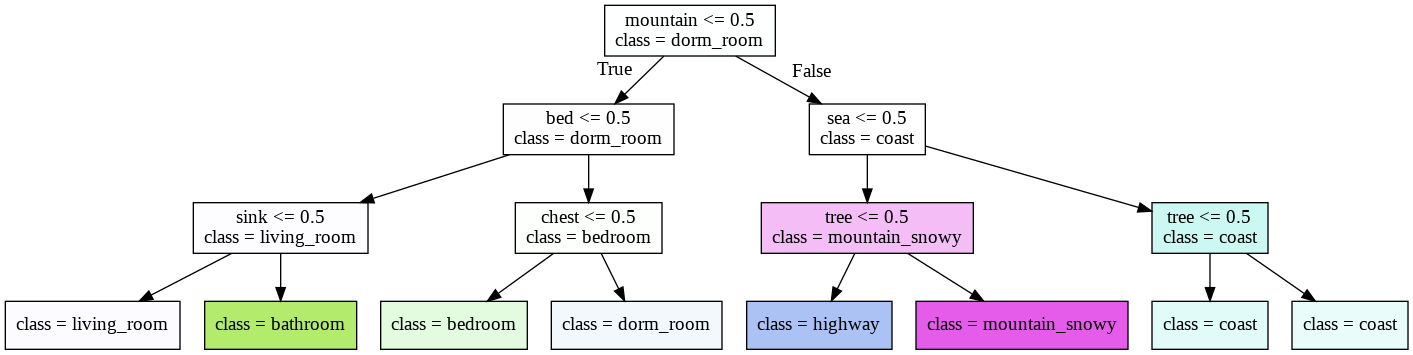

In [0]:
import graphviz
import pydotplus
import re
dot_data = sklearn.tree.export_graphviz(surrogate_tree, out_file='tree.dot',
                                feature_names=list(cluster_labels.values()),  
                                class_names=surrogate_tree.classes_, 
                                impurity = False,
                                # label = None,
                                proportion = False, 
                                filled=True,
                                # rounded=True, 
                                special_characters=False) 
f = pydotplus.graph_from_dot_file('tree.dot').to_string()
f = re.sub('(\\\\nsamples = [0-9]+)', '', f)
f = re.sub('(\\\\nvalue = \[.*[0-9]\])', '', f)
f = re.sub('(samples = [0-9]+)\\\\n', '', f)
with open('tree_modified.dot', 'w') as file:
    file.write(f)
graph = pydotplus.graphviz.graph_from_dot_file('tree_modified.dot')
# graph = graphviz.Source(dot_data)
from IPython.display import Image
display(Image(graph.create_png()))

In [0]:
from queue import Queue

In [0]:
n_nodes = surrogate_tree.tree_.node_count
children_left = surrogate_tree.tree_.children_left
children_right = surrogate_tree.tree_.children_right
feature = surrogate_tree.tree_.feature
threshold = surrogate_tree.tree_.threshold
nodes_classes = []
is_leave = []
for i in range(n_nodes):
  nodes_classes.append(surrogate_tree.classes_[np.argmax(surrogate_tree.tree_.value[i])])
  is_leave.append(1 if children_left[i]==children_right[i] else 0)
nodes_classes = np.array(nodes_classes)
is_leave = np.array(is_leave)

parent = -np.ones_like(children_right)
q = Queue()
q.put(0)
while not q.empty():
  u = q.get()
  if children_right[u] == children_left[u]:
    continue
  q.put(children_right[u])
  q.put(children_left[u])
  parent[children_right[u]] = u
  parent[children_left[u]] = u

In [0]:
node_indicator = surrogate_tree.decision_path(val_x)
predictions = surrogate_tree.predict(val_x)

In [0]:
def print_rule(sample_id):
  node_index = node_indicator.indices[node_indicator.indptr[sample_id]:
                                      node_indicator.indptr[sample_id + 1]]
  print(f'instance number {sample_id} is {predictions[sample_id]}')
  for node_id in node_index:
    if is_leave[node_id]:
      continue
    if (val_x[sample_id, feature[node_id]] <= threshold[node_id]):
      threshold_sign = "<="
    else:
      threshold_sign = ">"
    # print(f"decision id node {node_id} : (X_test[{sample_id}, {feature[node_id]}] (= {val_x[sample_id, feature[node_id]]}) {threshold_sign} {threshold[node_id]})")
    print(f"decision id node {node_id} : ({list(cluster_labels.values())[feature[node_id]]} (= {val_x[sample_id, feature[node_id]]}) {threshold_sign} {threshold[node_id]})")
    list(cluster_labels.values())

In [0]:
predictions[7]

'living_room'

In [0]:
print_rule(7)

instance number 7 is living_room
decision id node 0 : (mountain (= 0) <= 0.5)
decision id node 1 : (bed (= 0) <= 0.5)
decision id node 2 : (sink (= 0) <= 0.5)


In [0]:
def print_counterfactual(sample_id):
  node_index = node_indicator.indices[node_indicator.indptr[sample_id]:node_indicator.indptr[sample_id + 1]]
  pred = predictions[sample_id]
  counter_path = np.copy(node_index)
  child = counter_path[-1]
  par = parent[child]
  visited = np.zeros_like(parent)
  while par!=-1:
    if (is_leave[child] and nodes_classes[child]!=pred):
      break
    if (is_leave[child] and nodes_classes[child]==pred):
      visited[child] = 1
      child = par
      par = parent[child]
      counter_path = counter_path[:-1]
      continue
    if (visited[children_left[child]] == 1 and visited[children_right[child]] == 1):
      visited[child] = 1
      child = par
      par = parent[child]
      counter_path = counter_path[:-1]
      continue
    par = child 
    child = children_left[par] if visited[children_right[par]] else children_right[par]
    counter_path = np.append(counter_path, child)
  # print(counter_path)
  print(f'counter example class is {nodes_classes[child]}')
  old_node_id = 0
  for node_id in counter_path[1:]:
    if (node_id == children_left[old_node_id]):
      threshold_sign = "<="
    else:
      threshold_sign = ">"
    print(f"decision id node {old_node_id} : ({list(cluster_labels.values())[feature[old_node_id]]} {threshold_sign} {threshold[old_node_id]})")
    old_node_id = node_id
    if is_leave[node_id]:
      continue

In [0]:
print_counterfactual(7)

[0 1 2 4]
counter example class is bathroom
decision id node 0 : (mountain <= 0.5)
decision id node 1 : (bed <= 0.5)
decision id node 2 : (sink > 0.5)


In [0]:
np.argwhere(predictions=='bedroom')

array([[ 21],
       [ 33],
       [ 34],
       [ 63],
       [ 69],
       [ 80],
       [ 95],
       [111],
       [123],
       [128],
       [136],
       [144],
       [145],
       [182],
       [186],
       [192]])

In [0]:
# 2 is very good instance shows coast and how to go to mountain
# 31 is bathroom
# 21 is bedroom

In [0]:
print_rule(31)

instance number 31 is bathroom
decision id node 0 : (mountain (= 0) <= 0.5)
decision id node 1 : (bed (= 0) <= 0.5)
decision id node 2 : (sink (= 1) > 0.5)


In [0]:
print_counterfactual(31)

counter example class is living_room
decision id node 0 : (mountain <= 0.5)
decision id node 1 : (bed <= 0.5)
decision id node 2 : (sink <= 0.5)
